# Code for analyzing average AUC of swimmers in each of our sinks 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Union

# Expected inputs:
# - positions: np.ndarray of shape (T, N, 3) with columns [x, y, z]
# - sinks: one of the following formats:
#   1) Dict per sink with keys among {'name','ixmin','ixmax','iymin','iymax','izmin','izmax'}
#   2) List[Dict]
#   3) Tuple/List with 6 values: (xmin, xmax, ymin, ymax, zmin, zmax)
#   4) Tuple/List with 4 values: (xmin, xmax, ymin, ymax)  -> z treated as unbounded
# This cell computes, for each time step, the proportion of swimmers inside each sink and plots
# both a combined figure (all sinks on one axis) and separate subplots (one per sink).

SinkSpec = Union[Dict[str, float], Tuple[float, float, float, float], Tuple[float, float, float, float, float, float]]


def _normalize_sinks(sinks: Union[SinkSpec, List[SinkSpec]]) -> List[Dict[str, float]]:
	"""Coerce sinks into a uniform list of dicts with bounds and a name."""
	if isinstance(sinks, (dict, tuple, list)):
		sinks = [sinks] if not isinstance(sinks, list) else sinks
	else:
		raise ValueError("'sinks' must be a dict, tuple/list, or a list of those")

	normalized = []
	for i, s in enumerate(sinks):
		if isinstance(s, dict):
			name = s.get('name', f'sink_{i}')
			xmin = s.get('ixmin', s.get('xmin', -np.inf))
			xmax = s.get('ixmax', s.get('xmax',  np.inf))
			ymin = s.get('iymin', s.get('ymin', -np.inf))
			ymax = s.get('iymax', s.get('ymax',  np.inf))
			zmin = s.get('izmin', s.get('zmin', -np.inf))
			zmax = s.get('izmax', s.get('zmax',  np.inf))
		elif isinstance(s, (tuple, list)) and len(s) in (4, 6):
			name = f'sink_{i}'
			if len(s) == 4:
				xmin, xmax, ymin, ymax = s
				zmin, zmax = -np.inf, np.inf
			else:
				xmin, xmax, ymin, ymax, zmin, zmax = s
		else:
			raise ValueError("Each sink must be a dict with *min/*max keys or a 4/6-tuple of bounds")

		normalized.append({
			'name': name,
			'xmin': float(xmin), 'xmax': float(xmax),
			'ymin': float(ymin), 'ymax': float(ymax),
			'zmin': float(zmin), 'zmax': float(zmax),
		})
	return normalized


def compute_sink_proportions(positions: np.ndarray, sinks: Union[SinkSpec, List[SinkSpec]]):
	"""Return (proportions[S, T], names[S]) where proportions[s, t] is the fraction of swimmers in sink s at time t.

	positions: array of shape (T, N, D>=2). If D==2, z is treated as 0 and all z-bounds are effectively ignored.
	sinks: sink bounds in any accepted format (see _normalize_sinks).
	"""
	if not isinstance(positions, np.ndarray) or positions.ndim != 3:
		raise ValueError("positions must be a np.ndarray of shape (T, N, D)")
	T, N, D = positions.shape
	if D < 2:
		raise ValueError("positions must have at least 2 spatial dimensions (x,y)")

	norm_sinks = _normalize_sinks(sinks)
	S = len(norm_sinks)
	proportions = np.zeros((S, T), dtype=float)

	# Extract coordinates per time for speed
	for t in range(T):
		x = positions[t, :, 0]
		y = positions[t, :, 1]
		z = positions[t, :, 2] if D >= 3 else 0.0
		for s_idx, s in enumerate(norm_sinks):
			mask = (
				(x >= s['xmin']) & (x <= s['xmax']) &
				(y >= s['ymin']) & (y <= s['ymax']) &
				((z >= s['zmin']) & (z <= s['zmax']) if D >= 3 else True)
			)
			proportions[s_idx, t] = float(np.count_nonzero(mask)) / float(N)

	names = [s['name'] for s in norm_sinks]
	return proportions, names


def plot_sink_proportions_combined(proportions: np.ndarray, names: List[str], dt: float = 1.0, title: str = None):
	T = proportions.shape[1]
	t = np.arange(T) * float(dt)
	plt.figure(figsize=(9, 4))
	for i, name in enumerate(names):
		plt.plot(t, proportions[i], label=name, linewidth=2)
	plt.ylim(0.0, 1.0)
	plt.xlabel('time')
	plt.ylabel('proportion in sink')
	plt.grid(alpha=0.3)
	plt.legend()
	if title:
		plt.title(title)
	plt.tight_layout()
	plt.show()


def plot_sink_proportions_separate(proportions: np.ndarray, names: List[str], dt: float = 1.0, cols: int = 2, title: str = None):
	S, T = proportions.shape
	t = np.arange(T) * float(dt)
	rows = int(np.ceil(S / float(cols))) if S > 0 else 1
	fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, max(1, rows) * 3), sharex=True, sharey=True)
	axes = np.atleast_1d(axes).ravel()
	for i in range(S):
		ax = axes[i]
		ax.plot(t, proportions[i], linewidth=2)
		ax.set_title(names[i])
		ax.set_ylim(0.0, 1.0)
		ax.grid(alpha=0.3)
	# Hide any unused subplots
	for j in range(S, len(axes)):
		axes[j].axis('off')
	fig.supxlabel('time')
	fig.supylabel('proportion in sink')
	if title:
		fig.suptitle(title)
	fig.tight_layout()
	plt.show()


IndexSinkSpec = Union[Dict[str, int], Tuple[int, int, int, int], Tuple[int, int, int, int, int, int]]


def positions_to_grid_indices(positions: np.ndarray,
							   Lx: float, Ly: float, Lz: float,
							   Nx: int, Ny: int, Nz: int) -> np.ndarray:
	"""Map physical positions (m) to grid indices using floor(x/L*Nr) and clipping.
	positions shape: (T, N, 3)
	Returns int64 array of shape (T, N, 3) with columns [ix, iy, iz]."""
	if positions.ndim != 3 or positions.shape[2] < 3:
		raise ValueError("positions must be (T, N, 3)")
	T, N, _ = positions.shape
	ix = np.floor(positions[:, :, 0] / float(Lx) * int(Nx)).astype(np.int64)
	iy = np.floor(positions[:, :, 1] / float(Ly) * int(Ny)).astype(np.int64)
	iz = np.floor(positions[:, :, 2] / float(Lz) * int(Nz)).astype(np.int64)
	ix = np.clip(ix, 0, int(Nx) - 1)
	iy = np.clip(iy, 0, int(Ny) - 1)
	iz = np.clip(iz, 0, int(Nz) - 1)
	idx = np.empty((T, N, 3), dtype=np.int64)
	idx[:, :, 0] = ix
	idx[:, :, 1] = iy
	idx[:, :, 2] = iz
	return idx


def _normalize_index_sinks(sinks: Union[IndexSinkSpec, List[IndexSinkSpec]],
						   Ny: int, Nx: int, Nz: int) -> List[Dict[str, int]]:
	"""Coerce sinks into a uniform list of dicts with integer index bounds and a name.
	If some bounds are omitted, they default to the full range for that axis."""
	if isinstance(sinks, (dict, tuple, list)):
		sinks = [sinks] if not isinstance(sinks, list) else sinks
	else:
		raise ValueError("'sinks' must be a dict, tuple/list, or a list of those")

	norm = []
	for i, s in enumerate(sinks):
		if isinstance(s, dict):
			name = s.get('name', f'sink_{i}')
			ixmin = s.get('ixmin', 0)
			ixmax = s.get('ixmax', Nx - 1)
			iymin = s.get('iymin', 0)
			iymax = s.get('iymax', Ny - 1)
			izmin = s.get('izmin', 0)
			izmax = s.get('izmax', Nz - 1)
		elif isinstance(s, (tuple, list)) and len(s) in (4, 6):
			name = f'sink_{i}'
			if len(s) == 4:
				ixmin, ixmax, iymin, iymax = s
				izmin, izmax = 0, Nz - 1
			else:
				ixmin, ixmax, iymin, iymax, izmin, izmax = s
		else:
			raise ValueError("Each sink must be a dict with ix*/iy*/iz* keys or a 4/6-tuple of index bounds")

		# coerce to ints and clip within grid
		entry = {
			'name': name,
			'ixmin': int(max(0, min(ixmin, Nx - 1))),
			'ixmax': int(max(0, min(ixmax, Nx - 1))),
			'iymin': int(max(0, min(iymin, Ny - 1))),
			'iymax': int(max(0, min(iymax, Ny - 1))),
			'izmin': int(max(0, min(izmin, Nz - 1))),
			'izmax': int(max(0, min(izmax, Nz - 1))),
		}
		# ensure min<=max
		if entry['ixmin'] > entry['ixmax'] or entry['iymin'] > entry['iymax'] or entry['izmin'] > entry['izmax']:
			raise ValueError(f"Invalid bounds for {name}: mins must be <= maxes")
		norm.append(entry)
	return norm


def compute_sink_proportions_from_index_bounds(
	positions: np.ndarray,
	sinks: Union[IndexSinkSpec, List[IndexSinkSpec]],
	Lx: float, Ly: float, Lz: float,
	Nx: int, Ny: int, Nz: int,
):
	"""Compute per-sink proportions over time, with sinks defined in GRID INDEX space.

	positions: (T, N, 3) in meters
	sinks: dicts/tuples with ix/iy/iz min/max bounds
	L*, N*: box lengths (m) and grid resolution along each axis
	Returns: proportions (S, T), names (S)
	"""
	if not isinstance(positions, np.ndarray) or positions.ndim != 3:
		raise ValueError("positions must be (T, N, 3)")
	T, N, _ = positions.shape

	idx = positions_to_grid_indices(positions, Lx, Ly, Lz, Nx, Ny, Nz)
	norm_sinks = _normalize_index_sinks(sinks, Ny=Ny, Nx=Nx, Nz=Nz)
	S = len(norm_sinks)
	proportions = np.zeros((S, T), dtype=float)

	for t in range(T):
		ix_t = idx[t, :, 0]
		iy_t = idx[t, :, 1]
		iz_t = idx[t, :, 2]
		for s_idx, s in enumerate(norm_sinks):
			mask = (
				(ix_t >= s['ixmin']) & (ix_t <= s['ixmax']) &
				(iy_t >= s['iymin']) & (iy_t <= s['iymax']) &
				(iz_t >= s['izmin']) & (iz_t <= s['izmax'])
			)
			proportions[s_idx, t] = float(np.count_nonzero(mask)) / float(N)

	names = [s['name'] for s in norm_sinks]
	return proportions, names

In [2]:
import numpy as np
from typing import List, Dict, Tuple, Union

IndexSinkSpec = Union[Dict[str, int], Tuple[int, int, int, int], Tuple[int, int, int, int, int, int]]


def positions_to_grid_indices(positions: np.ndarray,
							   Lx: float, Ly: float, Lz: float,
							   Nx: int, Ny: int, Nz: int) -> np.ndarray:
	"""Map physical positions (m) to grid indices using floor(x/L*Nr) and clipping.
	positions shape: (T, N, 3)
	Returns int64 array of shape (T, N, 3) with columns [ix, iy, iz]."""
	if positions.ndim != 3 or positions.shape[2] < 3:
		raise ValueError("positions must be (T, N, 3)")
	T, N, _ = positions.shape
	ix = np.floor(positions[:, :, 0] / float(Lx) * int(Nx)).astype(np.int64)
	iy = np.floor(positions[:, :, 1] / float(Ly) * int(Ny)).astype(np.int64)
	iz = np.floor(positions[:, :, 2] / float(Lz) * int(Nz)).astype(np.int64)
	ix = np.clip(ix, 0, int(Nx) - 1)
	iy = np.clip(iy, 0, int(Ny) - 1)
	iz = np.clip(iz, 0, int(Nz) - 1)
	idx = np.empty((T, N, 3), dtype=np.int64)
	idx[:, :, 0] = ix
	idx[:, :, 1] = iy
	idx[:, :, 2] = iz
	return idx


def _normalize_index_sinks(sinks: Union[IndexSinkSpec, List[IndexSinkSpec]],
						   Ny: int, Nx: int, Nz: int) -> List[Dict[str, int]]:
	"""Coerce sinks into a uniform list of dicts with integer index bounds and a name.
	If some bounds are omitted, they default to the full range for that axis."""
	if isinstance(sinks, (dict, tuple, list)):
		sinks = [sinks] if not isinstance(sinks, list) else sinks
	else:
		raise ValueError("'sinks' must be a dict, tuple/list, or a list of those")

	norm = []
	for i, s in enumerate(sinks):
		if isinstance(s, dict):
			name = s.get('name', f'sink_{i}')
			ixmin = s.get('ixmin', 0)
			ixmax = s.get('ixmax', Nx - 1)
			iymin = s.get('iymin', 0)
			iymax = s.get('iymax', Ny - 1)
			izmin = s.get('izmin', 0)
			izmax = s.get('izmax', Nz - 1)
		elif isinstance(s, (tuple, list)) and len(s) in (4, 6):
			name = f'sink_{i}'
			if len(s) == 4:
				ixmin, ixmax, iymin, iymax = s
				izmin, izmax = 0, Nz - 1
			else:
				ixmin, ixmax, iymin, iymax, izmin, izmax = s
		else:
			raise ValueError("Each sink must be a dict with ix*/iy*/iz* keys or a 4/6-tuple of index bounds")

		# coerce to ints and clip within grid
		entry = {
			'name': name,
			'ixmin': int(max(0, min(ixmin, Nx - 1))),
			'ixmax': int(max(0, min(ixmax, Nx - 1))),
			'iymin': int(max(0, min(iymin, Ny - 1))),
			'iymax': int(max(0, min(iymax, Ny - 1))),
			'izmin': int(max(0, min(izmin, Nz - 1))),
			'izmax': int(max(0, min(izmax, Nz - 1))),
		}
		# ensure min<=max
		if entry['ixmin'] > entry['ixmax'] or entry['iymin'] > entry['iymax'] or entry['izmin'] > entry['izmax']:
			raise ValueError(f"Invalid bounds for {name}: mins must be <= maxes")
		norm.append(entry)
	return norm


def compute_sink_proportions_from_index_bounds(
	positions: np.ndarray,
	sinks: Union[IndexSinkSpec, List[IndexSinkSpec]],
	Lx: float, Ly: float, Lz: float,
	Nx: int, Ny: int, Nz: int,
):
	"""Compute per-sink proportions over time, with sinks defined in GRID INDEX space.

	positions: (T, N, 3) in meters
	sinks: dicts/tuples with ix/iy/iz min/max bounds
	L*, N*: box lengths (m) and grid resolution along each axis
	Returns: proportions (S, T), names (S)
	"""
	if not isinstance(positions, np.ndarray) or positions.ndim != 3:
		raise ValueError("positions must be (T, N, 3)")
	T, N, _ = positions.shape

	idx = positions_to_grid_indices(positions, Lx, Ly, Lz, Nx, Ny, Nz)
	norm_sinks = _normalize_index_sinks(sinks, Ny=Ny, Nx=Nx, Nz=Nz)
	S = len(norm_sinks)
	proportions = np.zeros((S, T), dtype=float)

	for t in range(T):
		ix_t = idx[t, :, 0]
		iy_t = idx[t, :, 1]
		iz_t = idx[t, :, 2]
		for s_idx, s in enumerate(norm_sinks):
			mask = (
				(ix_t >= s['ixmin']) & (ix_t <= s['ixmax']) &
				(iy_t >= s['iymin']) & (iy_t <= s['iymax']) &
				(iz_t >= s['izmin']) & (iz_t <= s['izmax'])
			)
			proportions[s_idx, t] = float(np.count_nonzero(mask)) / float(N)

	names = [s['name'] for s in norm_sinks]
	return proportions, names

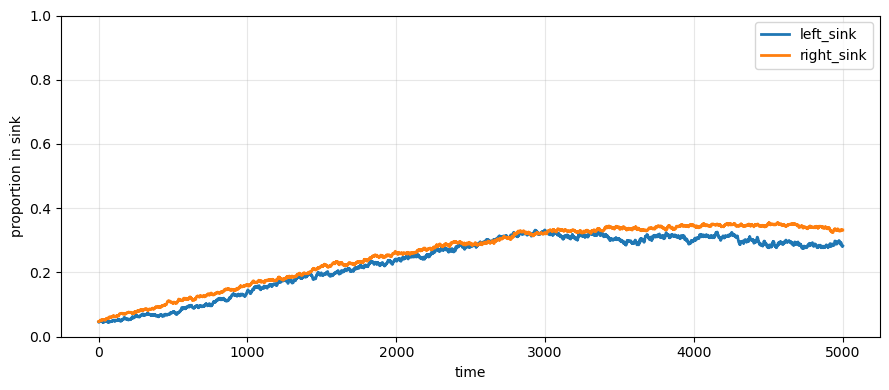

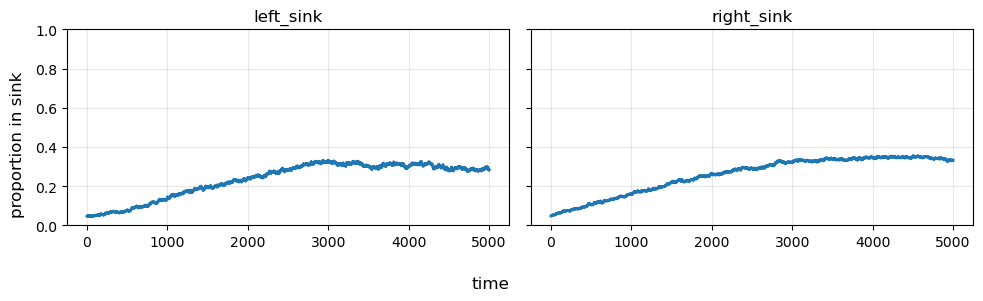

In [3]:
Ny, Nx, Nz = 30,100,100
Lx, Ly, Lz = 0.002, 0.0006, 0.002   # set to your sim's box lengths (m)
positions = np.load('/home/alabbasm/msbt/magnetotactic_modeling/model_testing/data/01_rev_n1000_t1000_noM_nobinding/pos_rev_n1000t1000_515.npy')
sinks = [
 	{'name': 'left_sink',  'ixmin': 20, 'ixmax': 40, 'iymin': 0, 'iymax': 30, 'izmin': 20, 'izmax': 40},
 	{'name': 'right_sink', 'ixmin': 60, 'ixmax': 80, 'iymin': 0, 'iymax': 30, 'izmin': 20, 'izmax': 40},
 ]
props, names = compute_sink_proportions_from_index_bounds(positions, sinks, Lx, Ly, Lz, Nx, Ny, Nz)
plot_sink_proportions_combined(props, names, dt=1.0)
plot_sink_proportions_separate(props, names, dt=1.0, cols=2)

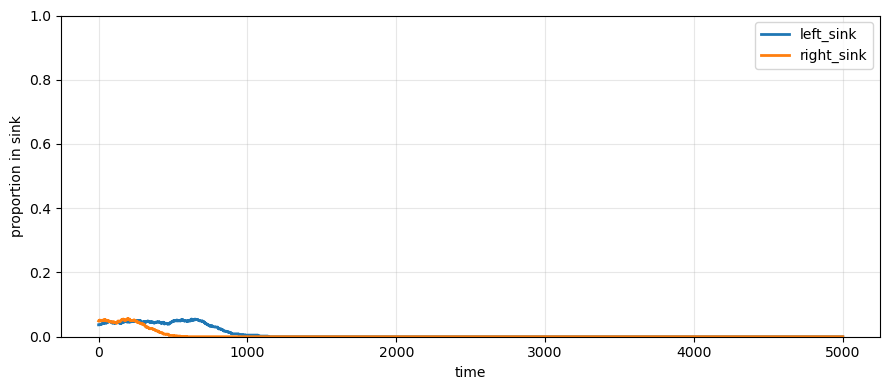

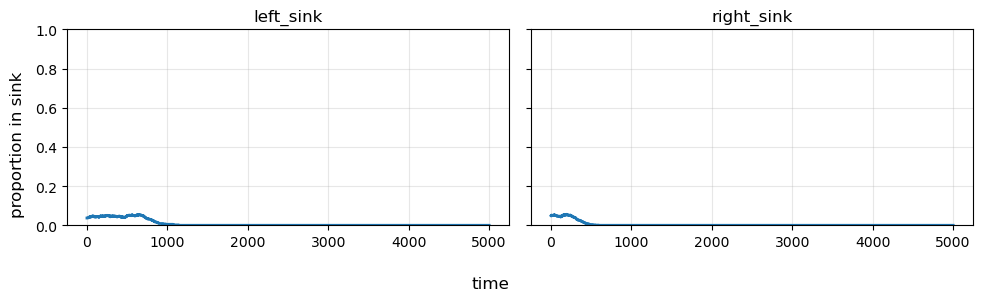

In [4]:
Ny, Nx, Nz = 30,100,100
Lx, Ly, Lz = 0.002, 0.0006, 0.002   # set to your sim's box lengths (m)
positions = np.load('/home/alabbasm/msbt/magnetotactic_modeling/model_testing/data/02_rev_n1000t1000_M_neg_nobinding/pos_rev_nobinding_neg_n1000t1000_515.npy')
sinks = [
 	{'name': 'left_sink',  'ixmin': 20, 'ixmax': 40, 'iymin': 0, 'iymax': 30, 'izmin': 20, 'izmax': 40},
 	{'name': 'right_sink', 'ixmin': 60, 'ixmax': 80, 'iymin': 0, 'iymax': 30, 'izmin': 20, 'izmax': 40},
 ]
props, names = compute_sink_proportions_from_index_bounds(positions, sinks, Lx, Ly, Lz, Nx, Ny, Nz)
plot_sink_proportions_combined(props, names, dt=1.0)
plot_sink_proportions_separate(props, names, dt=1.0, cols=2)

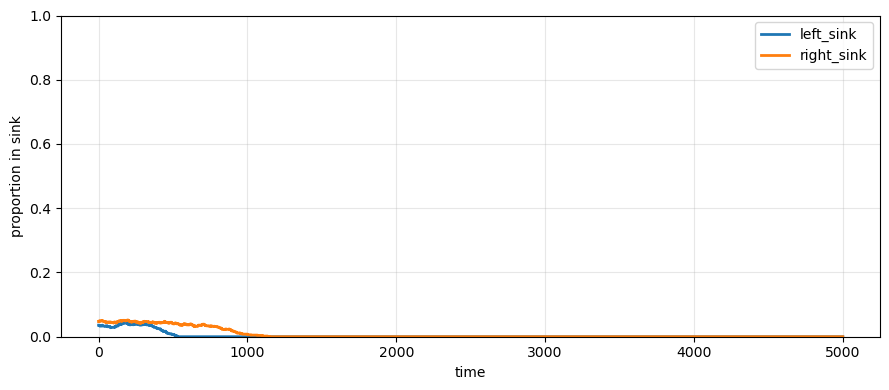

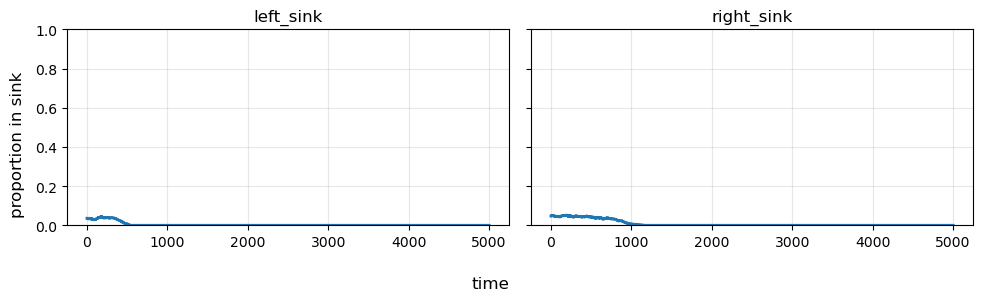

In [5]:
Ny, Nx, Nz = 30,100,100
Lx, Ly, Lz = 0.002, 0.0006, 0.002   # set to your sim's box lengths (m)
positions = np.load('/home/alabbasm/msbt/magnetotactic_modeling/model_testing/data/03_rev_n1000t1000_M_pos_nobinding/pos_rev_nobinding_pos_n1000t1000_515.npy')
sinks = [
 	{'name': 'left_sink',  'ixmin': 20, 'ixmax': 40, 'iymin': 0, 'iymax': 30, 'izmin': 20, 'izmax': 40},
 	{'name': 'right_sink', 'ixmin': 60, 'ixmax': 80, 'iymin': 0, 'iymax': 30, 'izmin': 20, 'izmax': 40},
 ]
props, names = compute_sink_proportions_from_index_bounds(positions, sinks, Lx, Ly, Lz, Nx, Ny, Nz)
plot_sink_proportions_combined(props, names, dt=1.0)
plot_sink_proportions_separate(props, names, dt=1.0, cols=2)

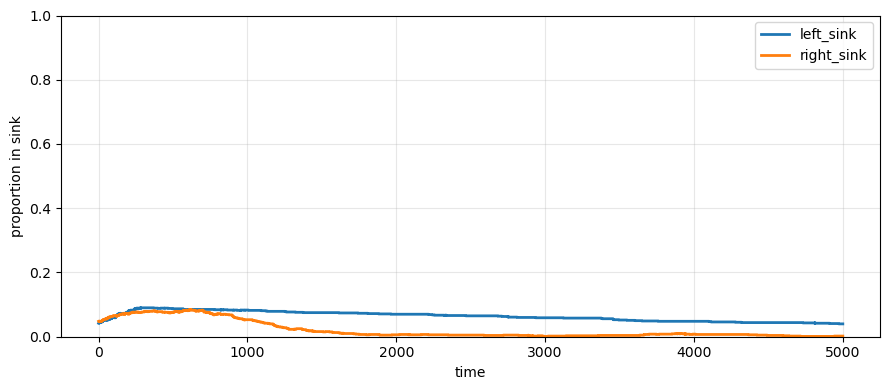

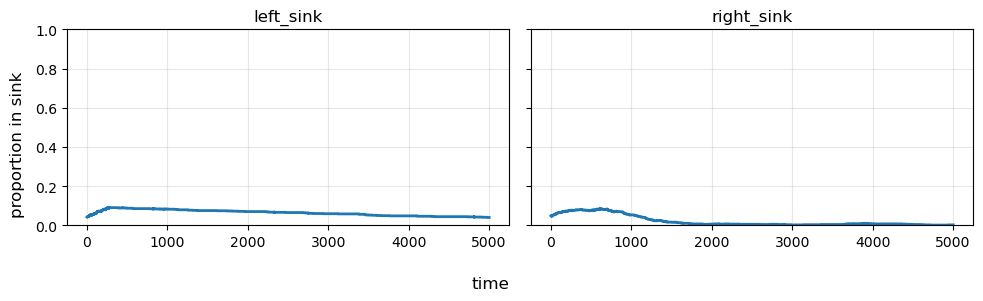

In [6]:
Ny, Nx, Nz = 30,100,100
Lx, Ly, Lz = 0.002, 0.0006, 0.002   # set to your sim's box lengths (m)
positions = np.load('/home/alabbasm/msbt/magnetotactic_modeling/model_testing/data/04_rev_n1000t1000_M_pos_binding515/pos_rev_nobinding_pos_binding_n1000t1000_515.npy')
sinks = [
 	{'name': 'left_sink',  'ixmin': 20, 'ixmax': 40, 'iymin': 0, 'iymax': 30, 'izmin': 20, 'izmax': 40},
 	{'name': 'right_sink', 'ixmin': 60, 'ixmax': 80, 'iymin': 0, 'iymax': 30, 'izmin': 20, 'izmax': 40},
 ]
props, names = compute_sink_proportions_from_index_bounds(positions, sinks, Lx, Ly, Lz, Nx, Ny, Nz)
plot_sink_proportions_combined(props, names, dt=1.0)
plot_sink_proportions_separate(props, names, dt=1.0, cols=2)

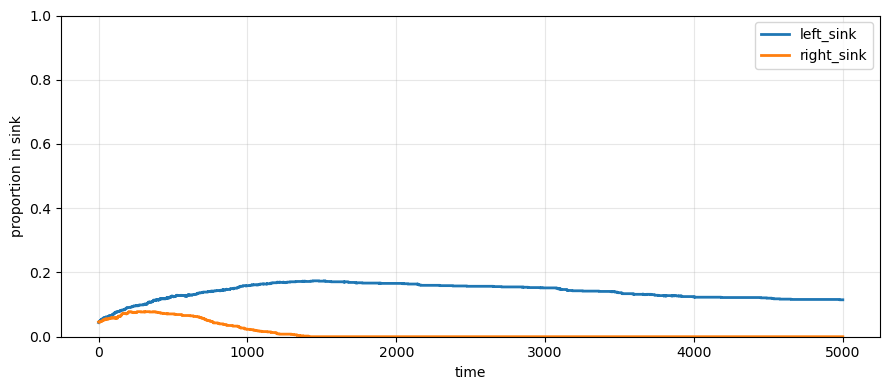

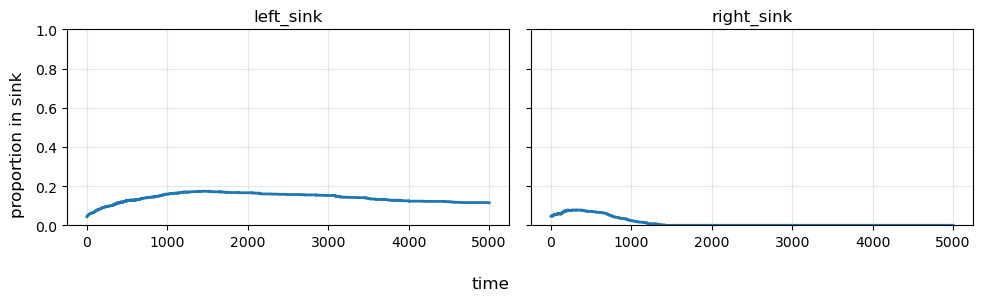

In [7]:
Ny, Nx, Nz = 30,100,100
Lx, Ly, Lz = 0.002, 0.0006, 0.002   # set to your sim's box lengths (m)
positions = np.load('/home/alabbasm/msbt/magnetotactic_modeling/model_testing/data/05_rev_n1000t1000_M_neg_binding515/pos_rev_nobinding_neg_binding_n1000t1000_515.npy')
sinks = [
 	{'name': 'left_sink',  'ixmin': 20, 'ixmax': 40, 'iymin': 0, 'iymax': 30, 'izmin': 20, 'izmax': 40},
 	{'name': 'right_sink', 'ixmin': 60, 'ixmax': 80, 'iymin': 0, 'iymax': 30, 'izmin': 20, 'izmax': 40},
 ]
props, names = compute_sink_proportions_from_index_bounds(positions, sinks, Lx, Ly, Lz, Nx, Ny, Nz)
plot_sink_proportions_combined(props, names, dt=1.0)
plot_sink_proportions_separate(props, names, dt=1.0, cols=2)

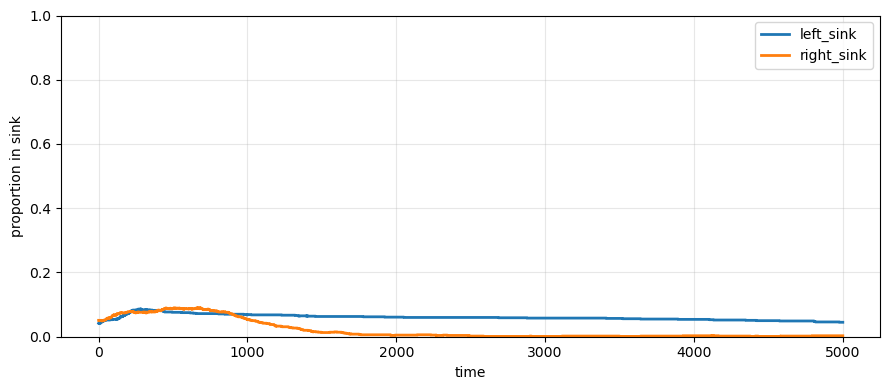

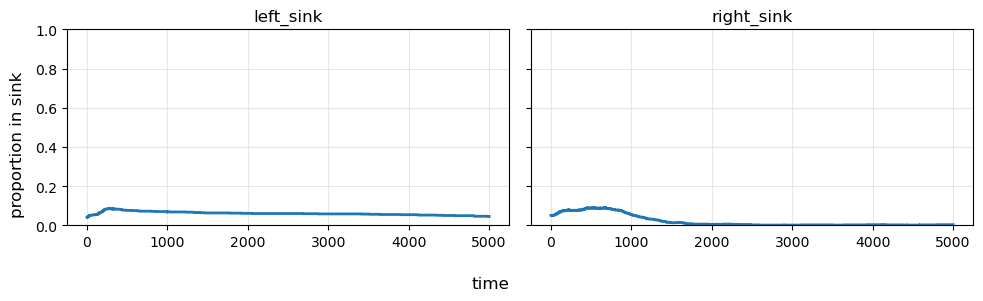

In [8]:
Ny, Nx, Nz = 30,100,100
Lx, Ly, Lz = 0.002, 0.0006, 0.002   # set to your sim's box lengths (m)
positions = np.load('/home/alabbasm/msbt/magnetotactic_modeling/model_testing/data/06_rev_n1000t1000_M_pos_binding155/pos_rev_nobinding_pos_binding_n1000t1000_155.npy')
sinks = [
 	{'name': 'left_sink',  'ixmin': 20, 'ixmax': 40, 'iymin': 0, 'iymax': 30, 'izmin': 20, 'izmax': 40},
 	{'name': 'right_sink', 'ixmin': 60, 'ixmax': 80, 'iymin': 0, 'iymax': 30, 'izmin': 20, 'izmax': 40},
 ]
props, names = compute_sink_proportions_from_index_bounds(positions, sinks, Lx, Ly, Lz, Nx, Ny, Nz)
plot_sink_proportions_combined(props, names, dt=1.0)
plot_sink_proportions_separate(props, names, dt=1.0, cols=2)

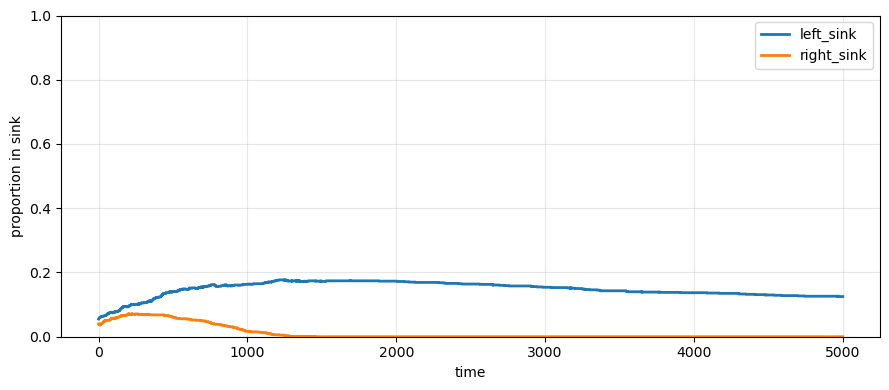

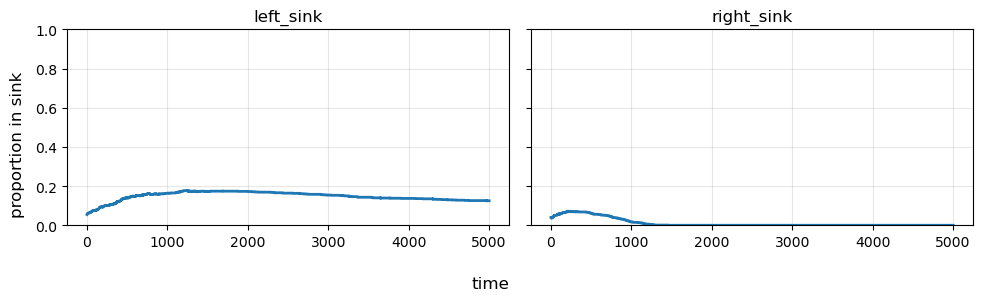

In [9]:
Ny, Nx, Nz = 30,100,100
Lx, Ly, Lz = 0.002, 0.0006, 0.002   # set to your sim's box lengths (m)
positions = np.load('/home/alabbasm/msbt/magnetotactic_modeling/model_testing/data/07_rev_n1000t1000_M_neg_neg_binding155/pos_rev_nobinding_neg_binding_n1000t1000_155.npy')
sinks = [
 	{'name': 'left_sink',  'ixmin': 20, 'ixmax': 40, 'iymin': 0, 'iymax': 30, 'izmin': 20, 'izmax': 40},
 	{'name': 'right_sink', 'ixmin': 60, 'ixmax': 80, 'iymin': 0, 'iymax': 30, 'izmin': 20, 'izmax': 40},
 ]
props, names = compute_sink_proportions_from_index_bounds(positions, sinks, Lx, Ly, Lz, Nx, Ny, Nz)
plot_sink_proportions_combined(props, names, dt=1.0)
plot_sink_proportions_separate(props, names, dt=1.0, cols=2)